# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
272622,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272623,2020-10-01,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272624,2020-10-02,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272625,2020-10-03,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272626,2020-10-04,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
272622,2020-09-30,Colombia,Vichada,14,0,0,14
272623,2020-10-01,Colombia,Vichada,14,0,0,14
272624,2020-10-02,Colombia,Vichada,14,0,0,14
272625,2020-10-03,Colombia,Vichada,14,0,0,14
272626,2020-10-04,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
195,2020-09-30,25741,2377,408,22956
196,2020-10-01,25973,2417,409,23147
197,2020-10-02,26169,2330,409,23430
198,2020-10-03,26376,2256,411,23709
199,2020-10-04,26484,2175,411,23898


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-09-30,33643605,9340435,1008343,23294827,0.014986,0.346200,0.041490
2020-10-01,33956148,9440051,1016884,23499213,0.014973,0.346023,0.041478
2020-10-02,34241876,9553289,1021722,23666865,0.014919,0.345584,0.041384
2020-10-03,34546886,9606817,1026764,23913305,0.014860,0.346099,0.041169
2020-10-04,34547373,9606211,1026765,23914397,0.014860,0.346110,0.041167


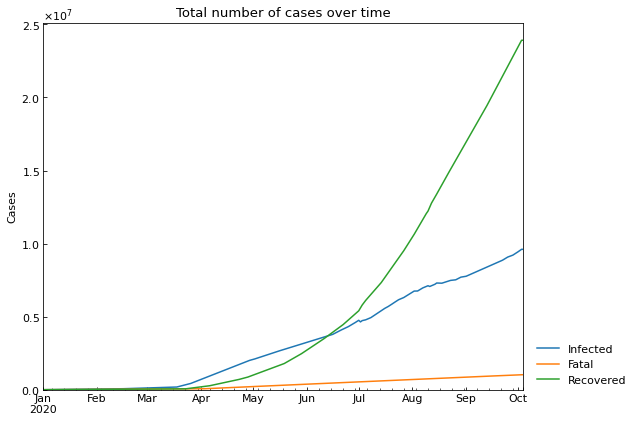

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
234,2020-09-30,83604,6032,1574,75998
235,2020-10-01,84235,6086,1582,76567
236,2020-10-02,84777,5988,1593,77196
237,2020-10-03,85354,5970,1599,77785
238,2020-10-04,85754,5861,1600,78293


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
232,2020-09-30,83010,5421,1564,76025
233,2020-10-01,83563,5402,1571,76590
234,2020-10-02,84215,5418,1578,77219
235,2020-10-03,84768,5371,1590,77807
236,2020-10-04,85339,5427,1597,78315


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
272622,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272623,2020-10-01,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272624,2020-10-02,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272625,2020-10-03,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272626,2020-10-04,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
232839,COL,Colombia,Vichada,2020-09-30,107808
232840,COL,Colombia,Vichada,2020-10-01,107808
232841,COL,Colombia,Vichada,2020-10-02,107808
232842,COL,Colombia,Vichada,2020-10-03,107808
232843,COL,Colombia,Vichada,2020-10-04,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
272622,2020-09-30,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272623,2020-10-01,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272624,2020-10-02,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272625,2020-10-03,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
272626,2020-10-04,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
272622,2020-09-30,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
272623,2020-10-01,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
272624,2020-10-02,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
272625,2020-10-03,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
272626,2020-10-04,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
273,2020-09-30,1,1,1,0,0,1,1,1,2,2,1,31.48
274,2020-10-01,1,1,1,0,0,1,1,1,2,2,1,31.48
275,2020-10-02,1,1,1,0,0,1,1,1,2,2,1,31.48
276,2020-10-03,1,1,1,0,0,1,1,1,2,2,1,31.48
277,2020-10-04,1,1,1,0,0,1,1,1,2,2,1,31.48


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
273,2020-09-30,1,1,1,0,0,1,1,1,2,2,1,31.48
274,2020-10-01,1,1,1,0,0,1,1,1,2,2,1,31.48
275,2020-10-02,1,1,1,0,0,1,1,1,2,2,1,31.48
276,2020-10-03,1,1,1,0,0,1,1,1,2,2,1,31.48
277,2020-10-04,1,1,1,0,0,1,1,1,2,2,1,31.48


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

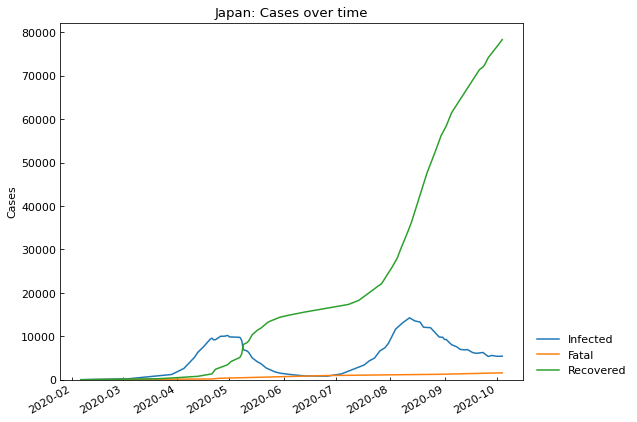

,Date,Confirmed,Infected,Fatal,Recovered
232,2020-09-30,83010,5421,1564,76025
233,2020-10-01,83563,5402,1571,76590
234,2020-10-02,84215,5418,1578,77219
235,2020-10-03,84768,5371,1590,77807
236,2020-10-04,85339,5427,1597,78315


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

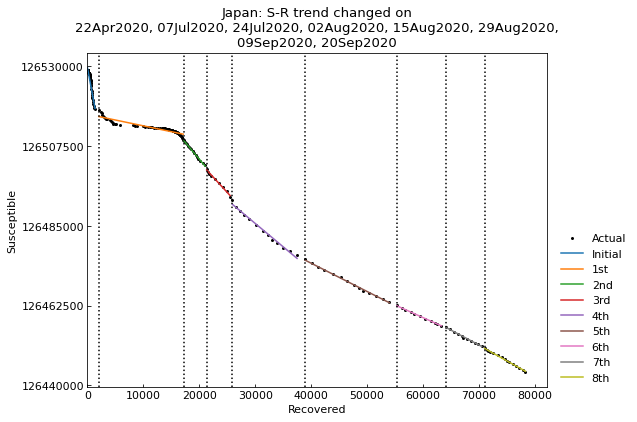

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,06Jul2020,126529100
2nd,Past,07Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,28Aug2020,126529100
6th,Past,29Aug2020,08Sep2020,126529100
7th,Past,09Sep2020,19Sep2020,126529100
8th,Past,20Sep2020,04Oct2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	8th phase (20Sep2020 - 04Oct2020): finished 1593 trials in 1 min  0 sec

	2nd phase (07Jul2020 - 23Jul2020): finished  658 trials in 0 min 20 sec

	1st phase (22Apr2020 - 06Jul2020): finished 1590 trials in 1 min  0 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1548 trials in 1 min  0 sec

	3rd phase (24Jul2020 - 01Aug2020): finished 1666 trials in 1 min  0 sec

	7th phase (09Sep2020 - 19Sep2020): finished  252 trials in 0 min  5 sec

	5th phase (15Aug2020 - 28Aug2020): finished  468 trials in 0 min 10 sec

	6th phase (29Aug2020 - 08Sep2020): finished  471 trials in 0 min 10 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1783 trials in 1 min  0 sec

Completed optimization. Total: 2 min 21 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/alpha2 [day],alpha1 [-],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.30,0.019837,0.000066,0.034879,0.007885,480,42,5064,0.020,9,0.948305,1548,1 min 0 sec
1st,Past,22Apr2020,06Jul2020,126529100,SIR-F,0.41,0.067744,0.000421,0.010210,0.022902,480,14,791,0.068,32,0.927731,1590,1 min 0 sec
2nd,Past,07Jul2020,23Jul2020,126529100,SIR-F,1.89,0.000158,0.000060,0.045682,0.024089,480,13,5573,0.000,7,0.030921,658,0 min 20 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.75,0.001692,0.000041,0.045933,0.026096,480,12,8228,0.002,7,0.020177,1666,1 min 0 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.49,0.000235,0.000131,0.034510,0.022957,480,14,2544,0.000,9,0.064337,1783,1 min 0 sec
5th,Past,15Aug2020,28Aug2020,126529100,SIR-F,0.82,0.000121,0.000293,0.026747,0.032156,480,10,1136,0.000,12,0.021017,468,0 min 10 sec
6th,Past,29Aug2020,08Sep2020,126529100,SIR-F,0.73,0.018803,0.000040,0.022841,0.030497,480,10,8425,0.019,14,0.016328,471,0 min 10 sec
7th,Past,09Sep2020,19Sep2020,126529100,SIR-F,0.82,0.001487,0.000531,0.028170,0.033689,480,9,627,0.001,11,0.016582,252,0 min 5 sec
8th,Past,20Sep2020,04Oct2020,126529100,SIR-F,0.86,0.001160,0.000375,0.025619,0.029313,480,11,889,0.001,13,0.029739,1593,1 min 0 sec


### Accuracy of estimation

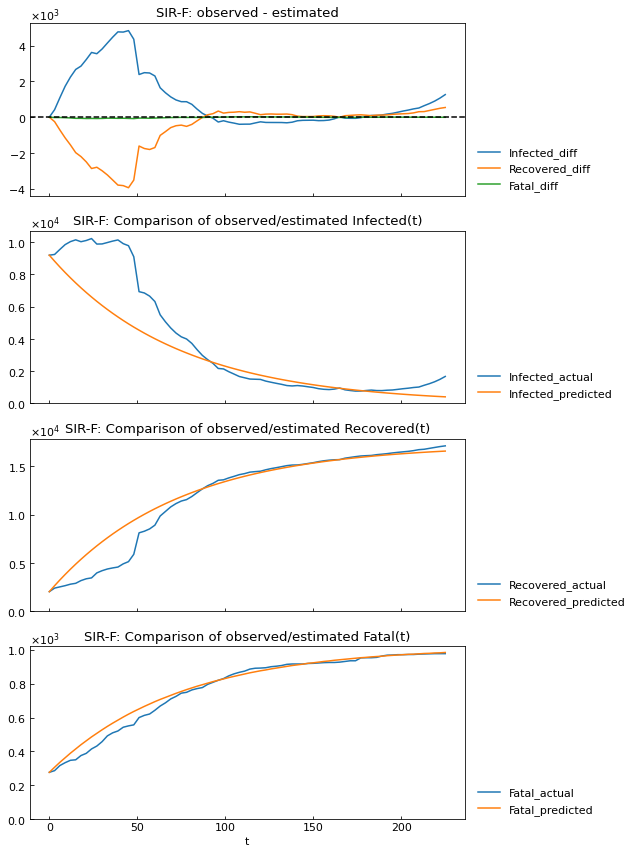

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.49

### Show parameter history

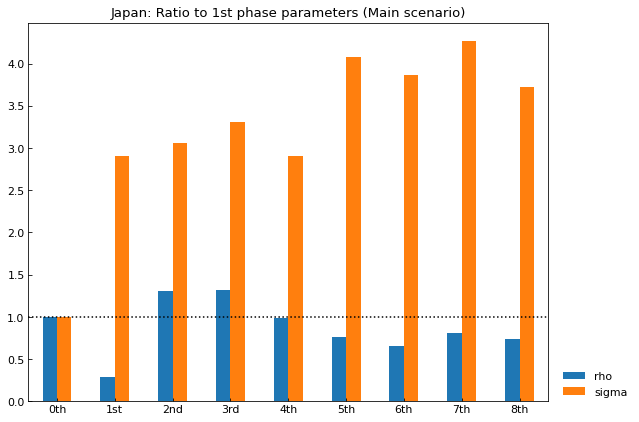

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
rho,1.0,0.292723,1.309725,1.316937,0.989414,0.766843,0.654863,0.807658,0.734501
sigma,1.0,2.904380,3.054842,3.309426,2.911338,4.077831,3.867518,4.272308,3.717349


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

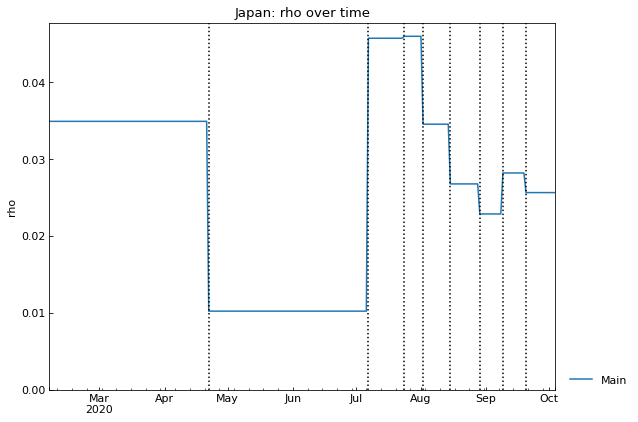

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

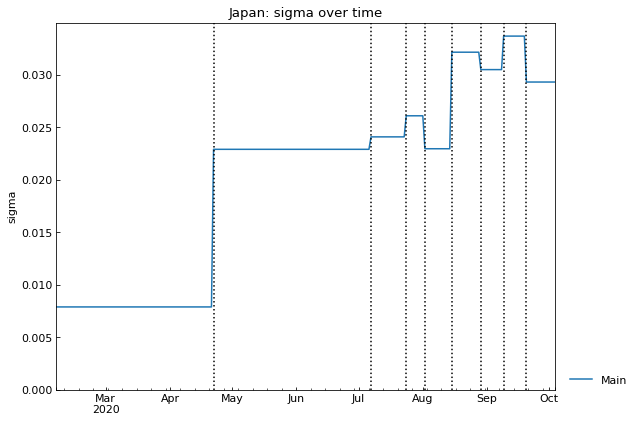

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

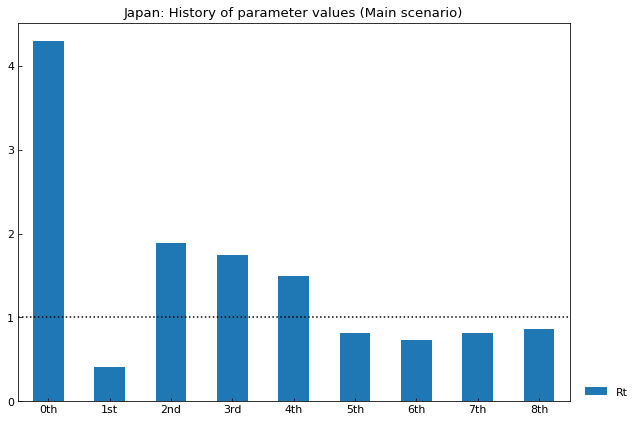

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
Rt,4.3,0.41,1.89,1.75,1.49,0.82,0.73,0.82,0.86


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

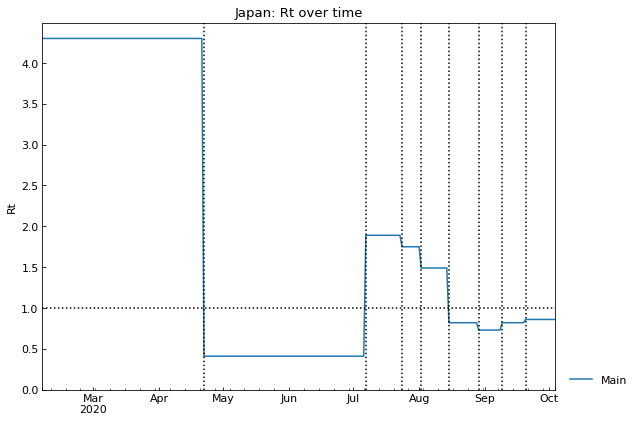

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

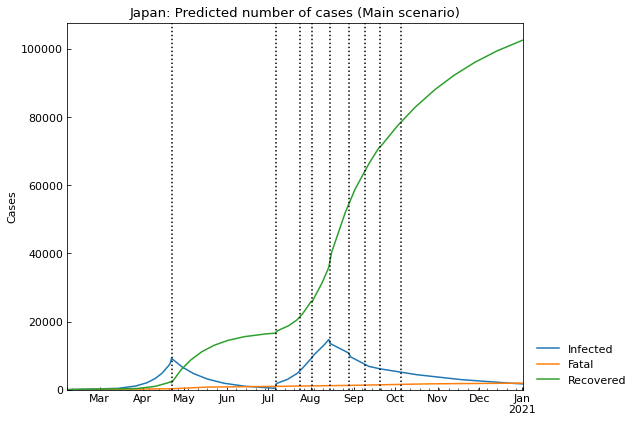

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,105666,1927,1782,101957
328,2020-12-30,105801,1929,1760,102112
329,2020-12-31,105936,1931,1739,102266
330,2021-01-01,106068,1933,1717,102418
331,2021-01-02,106200,1936,1696,102568


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.02931314079324723

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.05862628158649446

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.30   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.41   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.89   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.75   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.49   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.82   
         6th      Past  29Aug2020  08Sep2020   126529100  SIR-F  0.73   
         7th      Past  09Sep2020  19Sep2020   126529100  SIR-F  0.82   
         8th      Past  20Sep2020  04Oct2020   126529100  SIR-F  0.86   
         9th    Future  05Oct2020  01Jan2021   126529100  SIR-F  0.86   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.30   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.41   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.89   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.75   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.49   
         5th      Past  15Aug2020  28Aug2020   126529100  SIR-F  0.82   
         6th      Past  29Aug2020  08Sep2020   126529100  SIR-F  0.73   
         7th      Past  09Sep2020  19Sep2020   126529100  SIR-F  0.82   
         8th      Past  20Sep2020  04Oct2020   126529100  SIR-F  0.86   
         9th    Future  05Oct2020  03Nov2020   126529100  SIR-F  0.86   
         10th   Future  04Nov2020  01Jan2021   126529100  SIR-F  0.43   

                   theta     kappa       rho     sigma  tau  1/gamma [day]  \
Scenario Phase                                                               
Main     0th    0.019837  0.000066  0.034879  0.007885  480             42   
         1st    0.067744  0.000421  0.010210  0.022902  480             14   
         2nd    0.000158  0.000060  0.045682  0.024089  480             13   
         3rd    0.001692  0.000041  0.045933  0.026096  480             12   
         4th    0.000235  0.000131  0.034510  0.022957  480             14   
         5th    0.000121  0.000293  0.026747  0.032156  480             10   
         6th    0.018803  0.000040  0.022841  0.030497  480             10   
         7th    0.001487  0.000531  0.028170  0.033689  480              9   
         8th    0.001160  0.000375  0.025619  0.029313  480             11   
         9th    0.001160  0.000375  0.025619  0.029313  480             11   
Medicine 0th    0.019837  0.000066  0.034879  0.007885  480             42   
         1st    0.067744  0.000421  0.010210  0.022902  480             14   
         2nd    0.000158  0.000060  0.045682  0.024089  480             13   
         3rd    0.001692  0.000041  0.045933  0.026096  480             12   
         4th    0.000235  0.000131  0.034510  0.022957  480             14   
         5th    0.000121  0.000293  0.026747  0.032156  480             10   
         6th    0.018803  0.000040  0.022841  0.030497  480             10   
         7th    0.001487  0.000531  0.028170  0.033689  480              9   
         8th    0.001160  0.000375  0.025619  0.029313  480             11   
         9th    0.001160  0.000375  0.025619  0.029313  480             11   
         10th   0.001160  0.000375  0.025619  0.058626  480              5   

                1/alpha2 [day]  alpha1 [-]  1/beta [day]      RMSLE Trials  \
Scenario Phase                                                               
Main     0th              5064       0.020             9   0.948305   1548   
         1st               791       0.068            32   0.927731   1590   
         2nd              5573       0.000             7  0.0309212    658   
         3rd              8228       0.002             7  0.0201773   1666   
         4th              2544       0.000             9  0.0643374   1783 

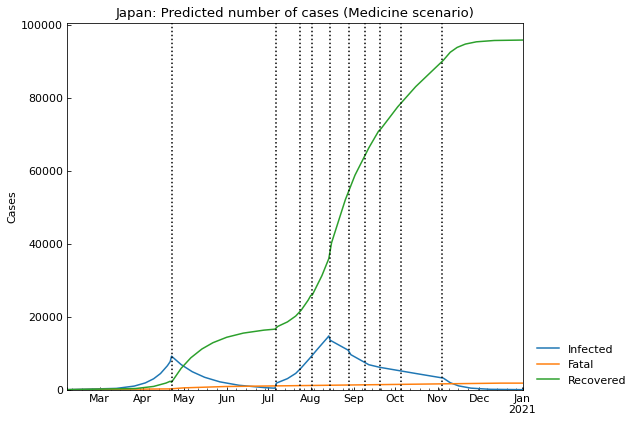

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,97581,1799,14,95768
328,2020-12-30,97583,1799,13,95771
329,2020-12-31,97584,1799,12,95773
330,2021-01-01,97585,1799,11,95775
331,2021-01-02,97585,1799,10,95776


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,10th_Rt
Main,14731,14Aug2020,1696,1936,-
Medicine,14731,14Aug2020,10,1799,0.43


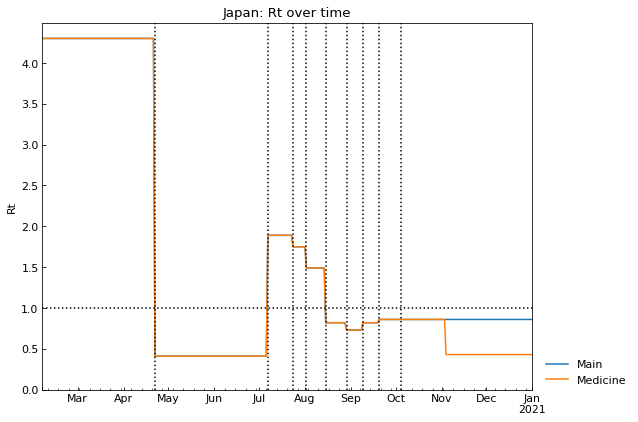

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

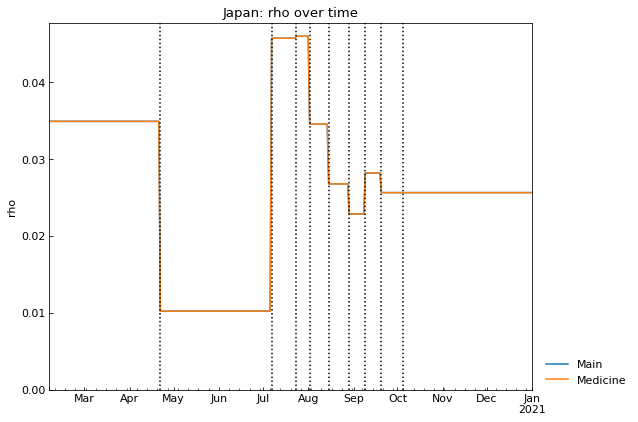

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

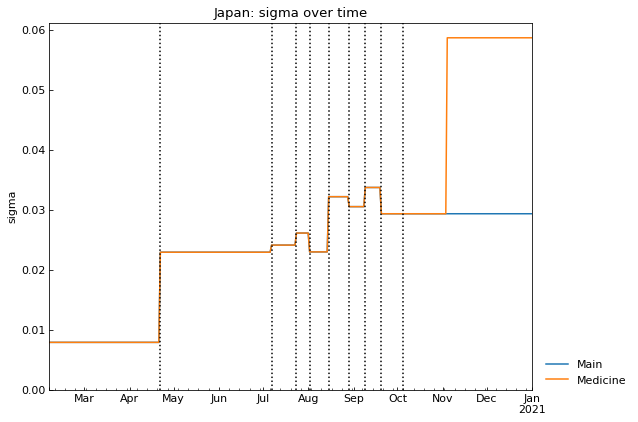

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

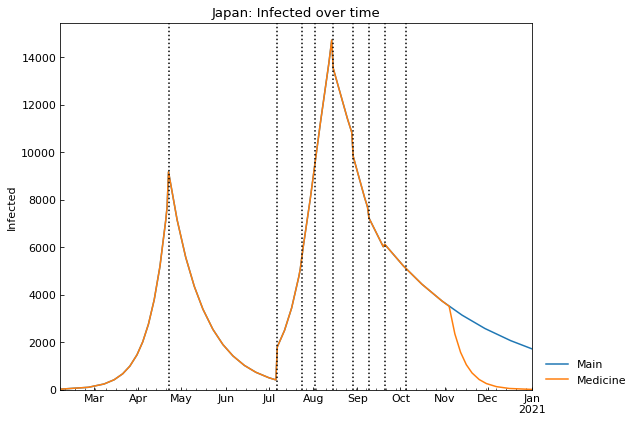

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")